In [1]:
%matplotlib inline
import numpy as np
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from decimal import Decimal
import scipy
from scipy import special
from scipy.integrate import trapz, simps
plt.style.use('ggplot')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
m_i = 2*1.6723e-27
k = 1.38e-23
joule_conv = 1.602e-19
charge = 1.602176e-19 

In [16]:
#reads poloidal and total B
def magnetic_read():
    magnetic_file_sep = open("Sep_Mag_field.txt",'r')
    next(magnetic_file_sep)
    
    angle_m = []
    Bp = []
    B = []
    
    for columns in (raw.strip().split() for raw in magnetic_file_sep):  
        angle_m.append(float(columns[0]))
        Bp.append(float(columns[1]))
        B.append(float(columns[2]))
    
    return angle_m,np.asarray(Bp),np.asarray(B)
angle_m,Bp,B = magnetic_read()

In [17]:
len(Bp)

360

In [3]:
#reads magnetic components
def magnetic_comp_read():
    magnetic_comp_file = open("Mag_components.txt",'r')
    next(magnetic_comp_file)
    
    angle_comp = []
    Br = []
    Bz = []
    
    for columns in (raw.strip().split() for raw in magnetic_comp_file):  
        angle_comp.append(float(columns[0]))
        Br.append(float(columns[1]))
        Bz.append(float(columns[2]))
    return angle_comp,np.asarray(Br),np.asarray(Bz)

angle_comp, Br, Bz = magnetic_comp_read()

In [4]:
#reads magnetic grad drifts
def magnetic_grad_read():
    magnetic_comp_file = open("Mag_grad_drifts.txt",'r')
    next(magnetic_comp_file)
    
    #angle_comp = []
    gradBR = []
    gradBZ = []
    #Bzeta = []
    
    for columns in (raw.strip().split() for raw in magnetic_comp_file):  
        #angle_comp.append(float(columns[0]))
        gradBR.append(float(columns[1]))
        gradBZ.append(float(columns[2]))
    return np.asarray(gradBR),np.asarray(gradBZ)

gradBR_geom, gradBZ_geom = magnetic_grad_read()

In [5]:
#reads magnetic curv drifts
def magnetic_curv_read():
    magnetic_comp_file = open("Mag_curv_drifts.txt",'r')
    next(magnetic_comp_file)
    
    curvR = []
    curvZ = []
    
    for columns in (raw.strip().split() for raw in magnetic_comp_file):  
        curvR.append(float(columns[1]))
        curvZ.append(float(columns[2]))
    return np.asarray(curvR),np.asarray(curvZ)

curvR_geom, curvZ_geom = magnetic_curv_read()

In [6]:
#reads perpendicular and parallel Ti
def ion_temp_read():
    file = open("Ion_temperatures.txt",'r')
    next(file)
    
    angle_tmp = []
    T_perp = []
    E_para = []
    
    for columns in (raw.strip().split() for raw in file):  
        angle_tmp.append(float(columns[0]))
        T_perp.append(float(columns[1]))
        E_para.append(float(columns[2]))
    
    return angle_tmp,T_perp,E_para
angle_tmp,T_perp,T_para = ion_temp_read()
T_perp = np.asarray([x for x in T_perp])
T_para = np.asarray([2*x for x in T_para])

In [10]:
V_perp_2 = (joule_conv*T_perp)/m_i
V_par_2 = (joule_conv*T_para)/m_i
Omega = (charge*B/(m_i))
mu = (0.5*m_i*V_perp_2)/B
gb = (joule_conv*T_perp)/(m_i*Omega)
cd = (joule_conv*T_para)/(m_i*Omega)

In [11]:
curvR = curvR_geom*(V_par_2/Omega)
curvZ = curvZ_geom*(V_par_2/Omega)
gradBR = gradBR_geom*(mu/(m_i*Omega))
gradBZ = gradBZ_geom*(mu/(m_i*Omega))
curvR2 = curvR_geom*cd
curvZ2 = curvZ_geom*cd
gradBR2 = gradBR_geom*gb
gradBZ2 = gradBZ_geom*gb

In [12]:
#reads densities
def densities_read():
    file = open("Sep_densities.txt",'r')
    next(file)
    
    den = []
    
    for columns in (raw.strip().split() for raw in file):  
        den.append(float(columns[1]))
    return np.asarray(den)

den = densities_read()

In [61]:
Mag_geom_R = gradBR_geom+curvR_geom
Mag_geom_Z = gradBZ_geom+curvZ_geom
Mag_geom = -(Bz*Mag_geom_R - Br*Mag_geom_Z)/Bp
Mag_R_flux = den*(gradBR+curvR)
Mag_Z_flux = den*(gradBZ+curvZ)
Mag_Flux = (Bz*Mag_R_flux - Br*Mag_Z_flux)/Bp
Mag_R_flux2 = den*(gradBR2+curvR2)
Mag_Z_flux2 = den*(gradBZ2+curvZ2)
Mag_Flux2 = (Bz*Mag_R_flux2 - Br*Mag_Z_flux2)/Bp

In [8]:
def total_read():
    total_file_sep = open("ti255_Sep_fluxes_total.txt",'r')
    next(total_file_sep)
    
    angle=[]
    Eq=[]
    Tur=[]
    R=[]
    Z=[]
    
    for columns in (raw.strip().split() for raw in total_file_sep):  
        angle.append(float(columns[0]))
        Eq.append(float(columns[1]))
        Tur.append(float(columns[2]))
        R.append(float(columns[3]))
        Z.append(float(columns[4]))
    return angle,Eq,Tur,R,Z

angle,Eq,Tur,R_s,Z_s = total_read()

In [3]:
def total_mag_read():
    total_file_sep = open("Mag_flux_total_new.txt",'r')
    next(total_file_sep)
    
    angle_s=[]
    Mag_s=[]
    R_s=[]
    Z_s=[]
    
    for columns in (raw.strip().split() for raw in total_file_sep):  
        angle_s.append(float(columns[0]))
        Mag_s.append(float(columns[1]))
        R_s.append(float(columns[2]))
        Z_s.append(float(columns[3]))
    return angle_s,Mag_s,R_s,Z_s

In [4]:
angle_s,Mag_s,R_s,Z_s = total_mag_read()

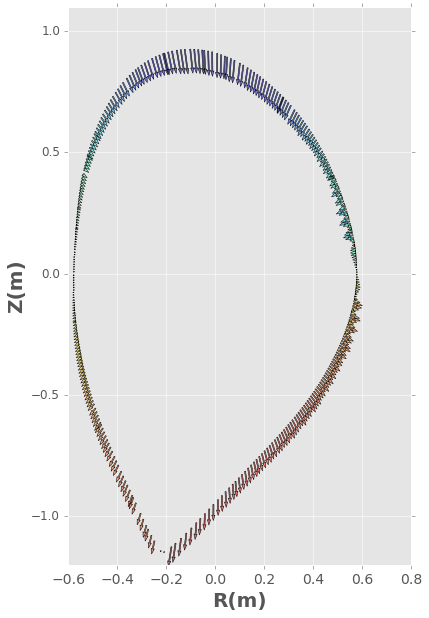

In [5]:
new_an = np.arctan2(Z_s,R_s)
Magx,Magy = Mag_s*np.cos(new_an), Mag_s*np.sin(new_an)
#plt.title('Equilibrium $e^{-}$ Heat Flux around the Separatrix')
#plt.title('Equilibrium Flux around the Inner Flux Surface')
plt.figure(figsize=(10,10))
plt.quiver(R_s, Z_s, Magx, Magy, Mag_s, alpha=.5)
plt.quiver(R_s, Z_s, Magx, Magy, edgecolor='k', facecolor='None', linewidth=.5)
plt.xlabel('R(m)')
plt.ylabel('Z(m)')
plt.xlim(-0.6,0.8)
plt.ylim(-1.2,1.1)
plt.axes().set_aspect(0.99)
plt.show()

In [6]:
def smoothing_alg(L):
    LF = np.roll(L,1)
    LB = np.roll(L,-1)
    LFF = np.roll(L,2)
    LBB = np.roll(L,-1)
    newL = (2.0*(LF + LB)+LFF+LBB)/6.0
    return newL

In [7]:
def smooth(L):
    sL = L
    for i in range(0,30):
        sL = smoothing_alg(sL)
    return sL

In [8]:
#Eq = np.asarray(Eq)
#Tur = np.asarray(Tur)
#Mag2 = -np.asarray(Mag_Flux2)
#SEq = smooth(Eq)
#STur = smooth(Tur)
SMag = np.asarray(smooth(Mag_s))
#SMag2 = -smooth(Mag_Flux2)
#SMag_geom = smooth(Mag_geom)

In [16]:
epsilon = 0.347
def an_dep2(x):
    A = 1/2*np.sqrt(epsilon)*np.sin((np.pi)*x/180.0)/(np.sqrt(1+np.cos((np.pi)*x/180.0)))
    return A

In [17]:
A = []
for an in range(0,180):
    A.append(-an_dep2(an))
for an in range(180,360):
    A.append(an_dep2(an))
    
Trapped = SMag*np.asarray(A)
Trapped2 = SMag2*np.asarray(A)

angle_trap = list(reversed(angle))

C:\Users\giannis\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [18]:
frt = np.sqrt(1-(B/np.amax(B)))
dtheta = (2*np.pi/180.)*angle[1]-(2*np.pi/180.)*angle[0]
frtplus = np.roll(frt,-1)
frtminus = np.roll(frt,+1)
dfrtdtheta = (frtplus-frtminus)/(2.*dtheta)
dfrtdtheta[0] = (frt[1]-frt[0])/dtheta
dfrtdtheta[-1] = (frt[-1]-frt[-2])/dtheta
g = -dfrtdtheta
Trapped3 = g*SMag2 

In [19]:
dGdth = []
for i in range(1,359):
    dGdth.append((frt[i+1]-frt[i-1])/((2*np.pi/180.)*angle[i+1]-(2*np.pi/180.)*angle[i-1]))
dGdth.append((frt[1]-frt[0])/((2*np.pi/180.)*angle[1]-(2*np.pi/180.)*angle[0]))
dGdth = dGdth + [(frt[-1]-frt[-2])/((2*np.pi/180.)*angle[-1]-(2*np.pi/180.)*angle[-2])]
dGdth = np.asarray(dGdth)
Trapped4 = smooth(dGdth)[0:180]*SMag[0:180]
Trapped44 = -smooth(dGdth)[180:]*SMag[180:]
Trapped444 = []
for elem in Trapped4:
    Trapped444.append(elem)
for elem in Trapped44:
    Trapped444.append(elem)
len(Trapped444)    

360

NameError: name 'g22' is not defined

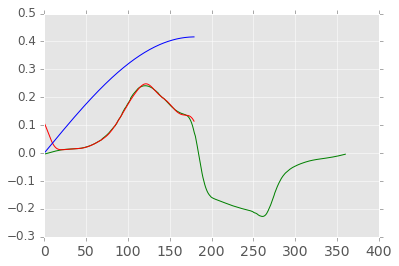

In [20]:
x = np.arange(0,180)
#plt.plot(angle,B,"r")
#plt.plot(angle,Bc,"b")
plt.plot(angle,-smooth(dGdth),"g")
plt.plot(x, smooth(g[0:180]),"r")
plt.plot(x, an_dep2(x),"b")
plt.plot(angle[0:180],smooth(g22[0:180]),"m")
#plt.plot(angle,g3,"g")
#plt.plot(angle, frt,"y")
plt.show()

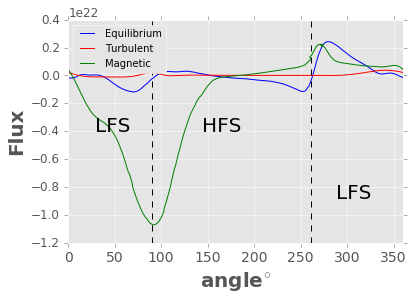

In [27]:
plt.figure()
plt.plot(angle,SEq,'b',label='Equilibrium')
plt.plot(angle,STur,'r',label='Turbulent')
plt.plot(angle_s,SMag,'g',label='Magnetic')
#plt.plot(angle,SMag2,'g',label='Magnetic')
#plt.plot(angle_trap,Trapped,'y',label='Trapped')
#plt.plot(angle_trap,Trapped2,'y',label='Trapped')
#plt.plot(angle_trap,np.asarray(Trapped444),'m',label='Trapped2')
plt.axvline(x=261,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.4, 0.5),textcoords='axes fraction')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.8, 0.2),textcoords='axes fraction')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.xlabel(r'angle$^{\circ}$')
plt.xlim(0.0,360.0)
plt.ylabel('Flux')
plt.legend(loc=2)
plt.show()


In [9]:
#top integral of a FSA of a nabla psi dot Q 
def Tokamak_Integral(Rarray,rarray,thetalist,weight):
    #index of starting and ending angles. Assume that all four arrays have the same size
    theta_start = 0
    theta_end = len(thetalist)-1
    prefactor = (thetalist[theta_end]-thetalist[theta_start])/(len(thetalist[theta_start:theta_end])-1)
    #dr/dtheta
    drdtheta = []
    for i in range(1,theta_end):
        drdtheta.append((rarray[i+1]-rarray[i-1])/(thetalist[i+1]-thetalist[i-1]))
    #linear correction for first and last element of derivative list
    dr2dtheta_start = (rarray[2]-2*rarray[1] + rarray[0])/(thetalist[2]-thetalist[0])**2
    dr2dtheta_end = (rarray[theta_end]-2*rarray[theta_end-1] + rarray[theta_end-2])/(thetalist[theta_end]-thetalist[theta_end-2])**2
    last_elem = drdtheta[-1] + dr2dtheta_end
    drdtheta.append(last_elem)
    first_elem = drdtheta[0] - dr2dtheta_start
    a = first_elem
    drdtheta_new = [a]+drdtheta
    der = np.asarray(drdtheta_new)
    #Integration scheme of the full square root 
    temp = weight*rarray*Rarray*np.sqrt(1 + (1/np.power(rarray,2))*np.power(der,2))
    Summation = (1/2)*weight[theta_start]*rarray[theta_start]*Rarray[theta_start]*np.sqrt(1+(1/rarray[theta_start]**2)*der[theta_start]**2) +\
    (1/2)*weight[theta_end]*rarray[theta_end]*Rarray[theta_end]*np.sqrt(1+(1/rarray[theta_end]**2)*der[theta_end]**2) +\
    np.sum(temp[theta_start+1:theta_end-2])
    Integral = 2*np.pi*prefactor*Summation
    #print("Integral = ",Integral)
    return Integral

In [10]:
#top integral of a FSA of a nabla psi dot Q 
def FSA_Integral(Bp, rarray,thetalist,weight):
    #index of starting and ending angles. Assume that all four arrays have the same size
    theta_start = 0
    theta_end = len(thetalist)-1
    Bpinv = np.asarray([1/x for x in Bp])
    prefactor = (thetalist[theta_end]-thetalist[theta_start])/(len(thetalist[theta_start:theta_end])-1)
    #dr/dtheta
    drdtheta = []
    for i in range(1,theta_end):
        drdtheta.append((rarray[i+1]-rarray[i-1])/(thetalist[i+1]-thetalist[i-1]))
    #linear correction for first and last element of derivative list
    dr2dtheta_start = (rarray[2]-2*rarray[1] + rarray[0])/(thetalist[2]-thetalist[0])**2
    dr2dtheta_end = (rarray[theta_end]-2*rarray[theta_end-1] + rarray[theta_end-2])/(thetalist[theta_end]-thetalist[theta_end-2])**2
    last_elem = drdtheta[-1] + dr2dtheta_end
    drdtheta.append(last_elem)
    first_elem = drdtheta[0] - dr2dtheta_start
    a = first_elem
    drdtheta_new = [a]+drdtheta
    der = np.asarray(drdtheta_new)
    #Integration scheme of the full square root 
    temp = weight*rarray*Bpinv*np.sqrt(1 + (1/np.power(rarray,2))*np.power(der,2))
    Summation = (1/2)*weight[theta_start]*rarray[theta_start]*Bpinv[theta_start]*np.sqrt(1+(1/rarray[theta_start]**2)*der[theta_start]**2) +\
    (1/2)*weight[theta_end]*rarray[theta_end]*Bpinv[theta_end]*np.sqrt(1+(1/rarray[theta_end]**2)*der[theta_end]**2) +\
    np.sum(temp[theta_start+1:theta_end-2])
    Integral = 2*np.pi*prefactor*Summation
    #print("Integral = ",Integral)
    return Integral

In [11]:
def Normalization(Bp,rarray,thetalist):
    #index of starting and ending angles. Assume that all four arrays have the same size
    weight = np.ones(len(thetalist))
    Bpinv = np.asarray([1/x for x in Bp])
    theta_start = 0
    theta_end = len(thetalist)-1
    prefactor = (thetalist[theta_end]-thetalist[theta_start])/(len(thetalist[theta_start:theta_end])-1)
    #dr/dtheta
    drdtheta = []
    for i in range(1,theta_end):
        drdtheta.append((rarray[i+1]-rarray[i-1])/(thetalist[i+1]-thetalist[i-1]))
    #linear correction for first and last element of derivative list
    dr2dtheta_start = (rarray[2]-2*rarray[1] + rarray[0])/(thetalist[2]-thetalist[0])**2
    dr2dtheta_end = (rarray[theta_end]-2*rarray[theta_end-1] + rarray[theta_end-2])/(thetalist[theta_end]-thetalist[theta_end-2])**2
    last_elem = drdtheta[-1] + dr2dtheta_end
    drdtheta.append(last_elem)
    first_elem = drdtheta[0] - dr2dtheta_start
    a = first_elem
    drdtheta_new = [a]+drdtheta
    der = np.asarray(drdtheta_new)
    #Integration scheme of the full square root 
    temp = weight*rarray*Bpinv*np.sqrt(1 + (1/np.power(rarray,2))*np.power(der,2))
    Summation = (1/2)*weight[theta_start]*rarray[theta_start]*Bpinv[theta_start]*np.sqrt(1+(1/rarray[theta_start]**2)*der[theta_start]**2) +\
    (1/2)*weight[theta_end]*rarray[theta_end]*Bpinv[theta_end]*np.sqrt(1+(1/rarray[theta_end]**2)*der[theta_end]**2) +\
    np.sum(temp[theta_start+1:theta_end-2])
    Integral = 2*np.pi*prefactor*Summation
    #print("Integral = ",Integral)
    return Integral

In [12]:
def major_R(R_value,Z_value):
    Rnorm = []#returning the R-distance for the integral function. This is the r-distance from the center of the tokamak to the flux point. 
    for r,z in zip(R_value,Z_value):
        Rnorm.append(r**2 + z**2)
    #Returning the distance from the axis of the tokamak for the R dzeta part of the integral.
    R = [x + 1.67 for x in R_value]
    return Rnorm, R
r,R = major_R(R_s,Z_s)

In [19]:
#particle sink accross the separatrix
#Equilibrium_Particle_Flux = Tokamak_Integral(R[0:360],r[0:360],angle[0:360],SEq[0:360])
#Turbulent_Particle_Flux = Tokamak_Integral(R[0:360],r[0:360],angle[0:360],STur[0:360])
Magnetic_Particle_Flux = Tokamak_Integral(R[0:360],r[0:360],angle_s[0:360],np.asarray(SMag[0:360]))
#Geometric_Magnetic_Particle_Flux = Tokamak_Integral(R[0:360],r[0:360],angle[0:360],Mag_geom[0:360])
#print("Equilibrium Particle sink = ",Equilibrium_Particle_Flux)
#print("Turbulent Particle sink = ",Turbulent_Particle_Flux)
print("Magnetic Particle sink = ",Magnetic_Particle_Flux)
#print("Geometric Magnetic Particle sink = ",Geometric_Magnetic_Particle_Flux)

Magnetic Particle sink =  -4.47348987758e+23


In [18]:
#FSA <Q grad\psi>
normalization = Normalization(Bp[0:360],r[0:360],angle_s[0:360])
#Equilibrium_grad_FSA = Tokamak_Integral(R[0:360],r[0:360],angle[0:360],SEq[0:360])/normalization
#Turbulent_grad_FSA = Tokamak_Integral(R[0:360],r[0:360],angle[0:360],STur[0:360])/normalization
Magnetic_grad_FSA = Tokamak_Integral(R[0:360],r[0:360],angle_s[0:360],SMag[0:360])/normalization
#Geometric_Magnetic_grad_FSA = Tokamak_Integral(R[0:360],r[0:360],angle[0:360],SMag_geom[0:360])/normalization
#print("Equilibrium grad FSA = ",Equilibrium_grad_FSA)
#print("Turbulent grad FSA = ",Turbulent_grad_FSA)
print("Magnetic grad FSA = ",Magnetic_grad_FSA)
#print("Geometric Magnetic grad FSA = ",Geometric_Magnetic_grad_FSA)
#print("cancellation Equilibrium = ",Equilibrium_grad_FSA/max(SEq))
#print("cancellation Turbulent = ",Turbulent_grad_FSA/max(STur))
print("cancellation Magnetic = ",Magnetic_grad_FSA/max(SMag))
#print("cancellation Geometric Magnetic = ",Geometric_Magnetic_grad_FSA/max(SMag_geom))

Magnetic grad FSA =  -8.14495948107e+19
cancellation Magnetic =  -0.0218145574766


In [20]:
#FSA
#Equilibrium_FSA = FSA_Integral(Bp[0:360],r[0:360],angle[0:360],SEq[0:360])/normalization
#Turbulent_FSA = FSA_Integral(Bp[0:360],r[0:360],angle[0:360],STur[0:360])/normalization
Magnetic_FSA = FSA_Integral(Bp[0:360],r[0:360],angle_s[0:360],SMag[0:360])/normalization
#Geometric_Magnetic_FSA = FSA_Integral(Bp[0:360],r[0:360],angle[0:360], SMag_geom[0:360])/normalization
#print("Equilibrium FSA = ",Equilibrium_FSA)
#print("Turbulent FSA = ",Turbulent_FSA)
print("Magnetic FSA = ",Magnetic_FSA)
#print("Geometric Magnetic FSA = ",Geometric_Magnetic_FSA)
#print("cancellation Equilibrium = ",Equilibrium_FSA/max(SEq))
#print("cancellation Turbulent = ",Turbulent_FSA/max(STur))
print("cancellation Magnetic = ",Magnetic_FSA/max(SMag))
#print("cancellation Geometric Magnetic = ",Geometric_Magnetic_FSA/max(SMag_geom))

Magnetic FSA =  7.57235005245e+20
cancellation Magnetic =  0.202809437955


In [42]:
print("Stag_Equilibrium = ",Tokamak_Integral(stag_R[0:240],stag_r[0:240],stag_angle[0:240],stag_SEq[0:240]))
print("Stag_Turbulent = ",Tokamak_Integral(stag_R[0:240],stag_r[0:240],stag_angle[0:240],stag_STur[0:240]))
print("Stag_Magnetic = ",Tokamak_Integral(stag_R[0:240],stag_r[0:240],stag_angle[0:240],stag_SMag[0:240]))

Stag_Equilibrium =  -2.04142983525e+23
Stag_Turbulent =  -3.64656044113e+22
Stag_Magnetic =  3.29159612644e+23
